<div style='background-image: url("https://www.geophysik.uni-muenchen.de/ROMY/theme/images/ringlaser_wideformat.jpg") ; padding: 0px ; background-size: cover ; border-radius: 15px ; height: 250px; background-position: 0% 80%'>
    <div style="float: left ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.9) ; width: 39% ; height: 150px">
        <div style="position: relative ; top: 50%;  transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.9) ; line-height: 100%"> <br>ROMY - <br> Systematic Analysis <br> of Modulation Index </div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.7)"></div>
        </div>
    </div>

## Importing

### Official Libraries

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import time 
import obspy

from scipy.signal import resample, hilbert, correlate
from tqdm import tqdm
from matplotlib.patches import Polygon, Patch


### Own Processing Methods

In [2]:
import sys
sys.path.insert(0, 'submodules')

In [3]:
from EchoPerformance import __echo_performance
from CreateSyntheticEventV2 import __create_synthetic_event_v2
from MinimizeResidual import __minimize_residual
from CreateLinearChirp import __create_linear_chirp
from Tapering import __tapering
from InstaFreqHilbert import __insta_freq_hilbert
from LoadMseed import __load_mseed
from Modulation import __modulation


In [4]:
# def __modulation(time_modeltrace, modeltrace, T, sps, mod_index):

#     timeline = time_modeltrace

#     Npts = int(T*sps)

#     # tt = np.arange(0, T, 1/sps/fraction)
#     tt = time_modeltrace

# #     modulation_index = abs(f_upper-sgnc)/f_upper
# #     print(modulation_index)
    
#     fm = sgnc + mod_index * modeltrace




#     print(' Integrating ... ')
#     t1 = time.time()

#     ifm = np.zeros(Npts+1)
#     summe = 0

#     for i in range(0, Npts+1):
#         summe += fm[i]
#         ifm[i] = 2*np.pi*summe

#     ifm = ifm / sps # to finish integral

#     t2 = time.time()

#     __echo_performance(t1, t2)



#     synthetic_signal = np.sin( 2 * np.pi * ifm )
#     # synthetic_signal = np.cos( 2 * np.pi * ifm )

#     # synthetic_signal = np.cos(2*np.pi * (sgnc + 0.01 * ifm ))

#     # synthetic_signal = 1.0 * np.sin(2*np.pi*sgnc * timeline - 0.001 * np.cos(modeltrace*timeline))

#     return timeline, synthetic_signal

### Own Plotting Methods

In [5]:
from MakeplotTraceAndSpectrum import __makeplot_trace_and_spectrum
from MakeplotTraceAndPSD import __makeplot_trace_and_psd
from MakeplotModulatedSignal import __makeplot_modulated_signal
from MakeplotDemodulationQuality import __makeplot_demodulation_quality
from Normalize import __normalize

In [6]:

def __run(sgnc, T, sps, oversampling, mod_index, f_lower, f_upper, syn_signal, taper_type, taper_percent=0.2):
    
    sps *= oversampling
    
    ## ___________________________________________________
    ## Synthetic Signal
    
    modeltrace, time_modeltrace = __create_linear_chirp(T, sps, f_lower, f_upper)

    
    ## __________________________________
    if syn_signal == 'trace':
        
        ## load trace or create and write one if not yet existing
        
        iname=f"data/SYN_T{int(T)}_fs{int(sps)}_f{f_lower}-{f_upper}.mseed"
        
        modeltrace, time_modeltrace = __load_mseed(iname, T, sps, f_lower, f_upper)

        modeltrace = __tapering(modeltrace, taper_type, taper_percent)

         ## normalize trace to avoid issues with demodulation
        modeltrace = __normalize(modeltrace)

    ## __________________________________
    elif syn_signal == 'chirp':
        
        ## generate normalized chrip signal 
        modeltrace, time_modeltrace = __create_linear_chirp(T, sps, f_lower, f_upper)

    ## __________________________________    
    elif syn_signal == 'real_trace':

        ## set starttime and endtime
        tbeg = obspy.UTCDateTime(2020, 10, 30, 12, 5)
        tend = tbeg + T


        RLAS, RLAS_inv = __querry_seismo_data("BW.RLAS..BJZ", 
                                              tbeg, 
                                              tend, 
                                              restitute=True,
                                              )

        RLAS[0].resample(sampling_rate=sps)

        RLAS[0].filter('bandpass', freqmin=f_lower, freqmax=f_upper, corners=4, zerophase=True)

        time_modeltrace = np.arange(0, T+1/sps, 1/sps)
        modeltrace = RLAS[0].data[0:time_modeltrace.size]

        modeltrace = __normalize(modeltrace)

    ## __________________________________
    else:
        print("Wrong choise!")

    __tapering(modeltrace, taper_type, taper_percent)

    ## ___________________________________________________
    ## Modulation
    
#     timeline, synthetic_signal = __modulation(time_modeltrace, modeltrace, T, sps, mod_index)
    synthetic_signal, timeline = __modulation(modeltrace,
                                              time_modeltrace, 
                                              sgnc, 
                                              T, 
                                              sps, 
                                              mod_index, 
                                              case = 3,
                                             )    
#     synthetic_signal = __tapering(synthetic_signal, taper_type, taper_percent)

#     __makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps, t1=0, t2=2);


    ## ___________________________________________________
    ## Downsample
    
    modeltrace = modeltrace[::oversampling]
    time_modeltrace = time_modeltrace[::oversampling]

    synthetic_signal = synthetic_signal[::oversampling]
    timeline = timeline[::oversampling]

    sps = 1/(timeline[1]-timeline[0])    
    
#     __makeplot_trace_and_psd(synthetic_signal, timeline, fmax=0.5*sps);

#     __makeplot_modulated_signal(synthetic_signal,timeline);

    ## ___________________________________________________
    ## Demodulation
    
    time_demod_signal, demod_signal = __insta_freq_hilbert(synthetic_signal, timeline, sps, sgnc)
    
    
#     demod_signal = demod_signal - sgnc
    demod_signal = demod_signal - np.median(demod_signal)

    
    
    cutoff = int(0.01*demod_signal.size)
    
    ## store cutoffs for displaying
    cut1 = np.array([i for i in demod_signal[:cutoff]])
    cut2 = np.array([i for i in demod_signal[-cutoff:]])
    
    ## zero out 1% at both ends
    demod_signal[:cutoff] = 0.0
    demod_signal[-cutoff:] = 0.0

    
    ## normalize original and demodulated signal
    demod_signal_norm = __normalize(demod_signal)
    modeltrace_norm = __normalize(modeltrace)

    
    ## ___________________________________________________
    ## CrossCorrelation  

    cross_corr = correlate(demod_signal, modeltrace, mode='same')
    cross_corr_lags = np.arange(-cross_corr.size//2+1,cross_corr.size//2+1,1)
    
    
    idx = abs(cross_corr).argmax()
    
    cc = cross_corr[idx]
    cclag = cross_corr_lags[idx]
    
    print(f"\n max lag CC: {cross_corr_lags.max()} \n min lag CC: {cross_corr_lags.min()}")

    print(f"\n maximal CC: {round(cross_corr[idx],3)} at lag: {cross_corr_lags[idx]}")
    
    ## ___________________________________________________
    ## Residuals 
    
    residual  = modeltrace - demod_signal
    
    residual_pre_opt  = modeltrace_norm - demod_signal_norm

    residual_post_opt, demod_signal_opt  = __minimize_residual(demod_signal_norm, modeltrace_norm)
    
    N = residual.size 
    
    rms_pre  = np.sqrt(np.mean(residual_pre_opt**2))
    rms_post = np.sqrt(np.mean(residual_post_opt**2))
    rms      = np.sqrt(np.mean(residual**2))
    
    print(f'cutoff: {cutoff} --> residual median: {np.median(residual_post_opt)}')

    
    ## ___________________________________________________
    ## Plot
    
#     __makeplot_demodulation_quality(timeline, 
#                                     modeltrace_norm, 
#                                     demod_signal_norm,
#                                     cross_corr,
#                                     cross_corr_lags,
#                                     cut1,
#                                     cut2,
#                                     );
    
    return cc, cclag, rms_pre, rms_post, rms


## Configuration

In [7]:

oversampling = 10

T = 160
sps = 5000

sgnc = 553

f_lower, f_upper = 0.01, 30.0

taper_type="window"

syn_signal = "trace"

freqs = np.arange(0, 600, 50)

# modulation_indicies = np.array([0.001, 0.003, 0.006, 0.01, 0.03, 0.06 ,0.1, 0.3, 0.6, 1, 2, 3, 4, 5, 10]) 
modulation_indicies = np.array([0.001, 0.005, 0.01, 0.05 ,0.1, 0.5, 1, 5, 10]) 

# modulation_indicies = np.logspace(-3, 1, num=11) 


## Test Modulation Index

In [8]:

ccs = np.zeros((modulation_indicies.size, freqs.size))
cclags = np.zeros((modulation_indicies.size, freqs.size))
rms_pres = np.zeros((modulation_indicies.size, freqs.size))
rms_posts = np.zeros((modulation_indicies.size, freqs.size))
rmss = np.zeros((modulation_indicies.size, freqs.size))

for i, m_ind in enumerate(modulation_indicies): 
    modulation_index = m_ind
    print(m_ind, i)
    for j, ff in enumerate(freqs):
        sgnc = ff
        
        cc, cclag, rms_pre, rms_post, rms = __run( sgnc, 
                                                   T, 
                                                   sps, 
                                                   oversampling,
                                                   modulation_index,
                                                   f_lower, 
                                                   f_upper, 
                                                   syn_signal,
                                                   taper_type, 
                                                   taper_percent=0.2,
                                                  )
    
        print(i,j, ccs[i,j])    
        ccs[i][j] = cc
        cclags[i][j] = cclag
        rms_pres[i][j] = rms_pre
        rms_posts[i][j] = rms_post
        rmss[i][j] = rms
    

0.001 0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.31 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: -20847027.335 at lag: 176

optimized: original -  0.711 * model + 0.003

cutoff: 8000 --> residual median: 0.000763357473828801
0 0 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.29 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 4718.561 at lag: 0

optimized: original -  1.567 * model + -0.0

cutoff: 8000 --> residual median: -0.00038930990918383337
0 1 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.27 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 4718.581 at lag: 0

optimized: original -  1.927 * model + -0.002

cutoff: 8000 --> residual median: -0.002686167308558426
0 2 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.44 sec
1 nan removed !

 max lag CC: 40000

1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 47185.613 at lag: 0

optimized: original -  0.984 * model + -0.0

cutoff: 8000 --> residual median: -0.00031527523969813857
2 4 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.45 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 47185.615 at lag: 0

optimized: original -  0.968 * model + -0.0

cutoff: 8000 --> residual median: -0.00043818940973716636
2 5 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.45 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 47185.542 at lag: 0

optimized: original -  1.081 * model + 0.001

cutoff: 8000 --> residual median: 0.0009672609131896048
2 6 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.52 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 47185.615 at lag: 0

optimized: original -  1.224 * model 


Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.26 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 471856.086 at lag: 0

optimized: original -  1.004 * model + -0.0

cutoff: 8000 --> residual median: -0.00013144397968434252
4 9 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.23 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 471857.59 at lag: 0

optimized: original -  1.006 * model + -0.004

cutoff: 8000 --> residual median: -0.001670100594708901
4 10 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.24 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 471856.094 at lag: 0

optimized: original -  1.004 * model + -0.0

cutoff: 8000 --> residual median: -0.000149756688183747
4 11 0.0
0.5 5

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.44 sec
1 nan removed !

 max lag CC: 400000 


 elapsed time: 4.29 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 23592755.975 at lag: 0

optimized: original -  1.001 * model + -0.0

cutoff: 8000 --> residual median: 1.235798085065954e-05
7 1 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.45 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 23592800.963 at lag: 0

optimized: original -  1.0 * model + -0.0

cutoff: 8000 --> residual median: -7.50555084148407e-06
7 2 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.32 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 23592800.563 at lag: 0

optimized: original -  1.0 * model + -0.0

cutoff: 8000 --> residual median: -4.706185100705751e-06
7 3 0.0

Modulation option 3 is executed ...

 --> integrating ... 

 elapsed time: 4.19 sec
1 nan removed !

 max lag CC: 400000 
 min lag CC: -400000

 maximal CC: 23592799.962 at lag: 0

optimize

In [9]:

def __makeplot_quality_quantity_mind(xaxis, mind, ccs, cclags, rms_pres, rms_posts, rmss):

    fig, ax = plt.subplots(2,2, figsize=(15,8))

    font = 15
    
    colors = ['darkred', 'darkorange', 'lightgreen', 'darkgreen', 'cyan', 'darkblue', 'purple', 'pink']
    
    fig.subplots_adjust(hspace=0.3)
    
    ## ________________________________________

    for k in range(len(ccs)-1):
        ax[0,0].plot(xaxis, ccs[k][:], color=colors[k], ls='--', label='max. CC')
        ax[0,1].plot(xaxis, cclags[k][:], color=colors[k], ls='--', label='lag of max. CC')
        ax[1,0].plot(xaxis, rms_pres[k][:], color=colors[k], ls='--', label='rmse norm.')
        ax[1,1].plot(xaxis, rmss[k][:], color=colors[k], ls='--', label='rmse total')

        ax[0,0].scatter(xaxis, ccs[k][:], color=colors[k], ls='-', label='max. CC')
        ax[0,1].scatter(xaxis, cclags[k][:], color=colors[k], ls='-', label='lag of max. CC')
        ax[1,0].scatter(xaxis, rms_pres[k][:], color=colors[k], ls='-', label='rmse norm.')
        ax[1,1].scatter(xaxis, rmss[k][:], color=colors[k], ls='-', label='rmse total')

    ## ________________________________________


    ax[0,0].grid(alpha=0.5, ls='--')

    ax[0,0].set_xlabel("carrier frequency (Hz)", fontsize=font)
    ax[0,0].set_ylabel("max. cross-correlation", fontsize=font)
    ax[0,0].set_yscale("log")
    
    ## ________________________________________


    ax[0,1].grid(alpha=0.5, ls='--')

    ax[0,1].set_xlabel("carrier frequency (Hz)", fontsize=font)
    ax[0,1].set_ylabel("cross-correlation lag", fontsize=font)
    ax[0,1].set_ylim(-1,1)
    ## ________________________________________


    ax[1,0].grid(alpha=0.5, ls='--')

    ax[1,0].set_xlabel("carrier frequency (Hz)", fontsize=font)
    ax[1,0].set_ylabel("root mean square error", fontsize=font)
    ax[1,0].set_yscale("log")

    ## ________________________________________


    ax[1,1].grid(alpha=0.5, ls='--')

    ax[1,1].set_xlabel("carrier frequency (Hz)", fontsize=font)
    ax[1,1].set_ylabel("root mean square error", fontsize=font)
    
    ax[0,0].tick_params(labelsize=font-2)
    ax[1,0].tick_params(labelsize=font-2)
    ax[0,1].tick_params(labelsize=font-2)
    ax[1,1].tick_params(labelsize=font-2)
    ax[1,1].set_yscale("log")
    
    ## add legend 
#     legend_elements = [Patch(facecolor='green', edgecolor='green', label='Q0'),
#                        Patch(facecolor='yellow', edgecolor='yellow', label='Q1'),
#                        Patch(facecolor='darkorange', edgecolor='darkorange', label='Q2'),
#                        Patch(facecolor='darkred', edgecolor='darkred', label='Q3')
#                       ]

#     ax[0,0].legend(handles=legend_elements, loc='upper center', fontsize=font, ncol=9, edgecolor='black')
    ax[0,1].legend([mind[0],
                   mind[1],
                   mind[2],
                   mind[3],
                   mind[4],
                   mind[5],
                   mind[6],
                   mind[7]],
                   fontsize=font,
                   bbox_to_anchor=(1,0.3),
                   loc="upper left",
                  )
    
    plt.show();

#     ax[1,1].legend(fontsize=font-2)
    
    return fig


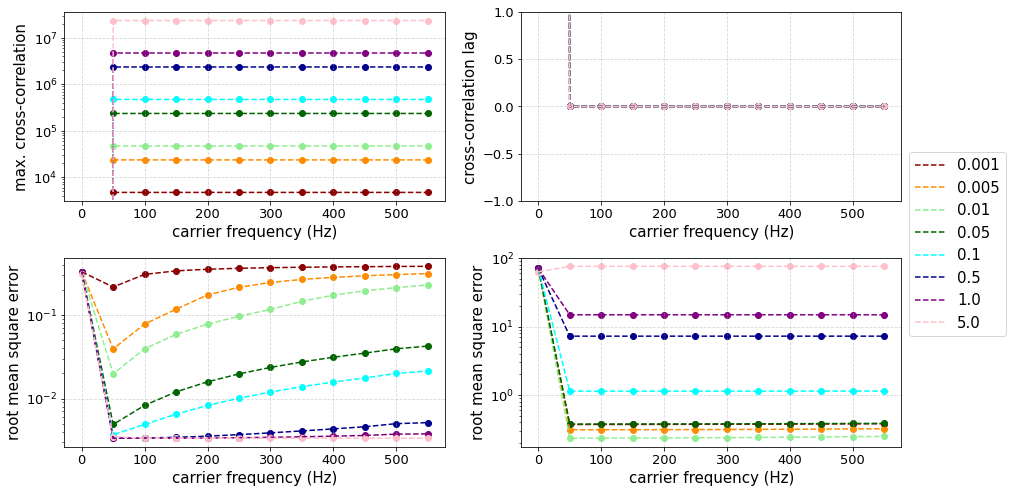

In [10]:

fig = __makeplot_quality_quantity_mind(freqs, 
                                       modulation_indicies, 
                                       ccs, 
                                       cclags, 
                                       rms_pres, 
                                       rms_posts, 
                                       rmss,
                                      )

fig.savefig(f"plots/test_mod-ind_{syn_signal}_{modulation_indicies[0]}-{modulation_indicies[-1]}_T{T}_fs{sps}_f{f_lower}-{f_upper}_S{sgnc}.pdf", dpi=300, format='pdf')
